# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [2]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Revise
using BayesianModels

# Plotting function
include("plotting.jl");

  Activating environment at `~/Repositories/BayesianModels.jl/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1317


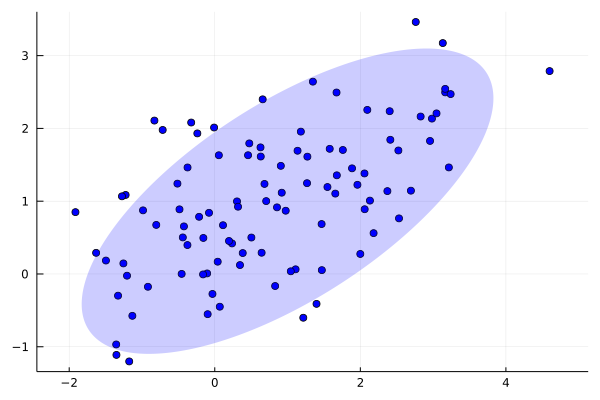

In [102]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[2 1; 1.0  1.1]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    hcat([μ + L*randn(T, 2) for i in 1:n]...)
end


X = draw(100, μₓ, Σₓ)
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [103]:
D = 2
W₀ = Matrix{Float64}(I, D, D)
μ₀ = zeros(D)
Σ₀ = Matrix{Float64}(I, D, D)
pstrength = 1

μ = BayesianParameter(EFD.Normal(μ₀, pstrength * Σ₀), 
               EFD.Normal(μ₀, pstrength * Σ₀))

Λ = BayesianParameter(EFD.Wishart(W₀, D - 1 + pstrength), 
               EFD.Wishart(W₀, D - 1 + pstrength))

model_full = BayesianModels.NormalIndependentParams{D}(μ, Λ)

BayesianModels.NormalIndependentParams (
  (μ): BayesianParameter
  (Λ): BayesianParameter
)


In [104]:
β₀ = 1
μ₀ = zeros(D)
diagΣ₀ = ones(D)
pstrength = 1


μ = BayesianParameter(EFD.NormalDiag(μ₀, pstrength * diagΣ₀), 
                      EFD.NormalDiag(μ₀, pstrength * diagΣ₀))

λ = Tuple(
    BayesianParameter(EFD.Gamma(pstrength, β₀), 
                      EFD.Gamma(pstrength, β₀))
    for i in 1:D
)

model_diag = BayesianModels.NormalDiagIndependentParams{D}(μ, λ)

BayesianModels.NormalDiagIndependentParams (
  (μ): BayesianParameter
  (λ): [
    (1): BayesianParameter
    (2): BayesianParameter
  ]
)


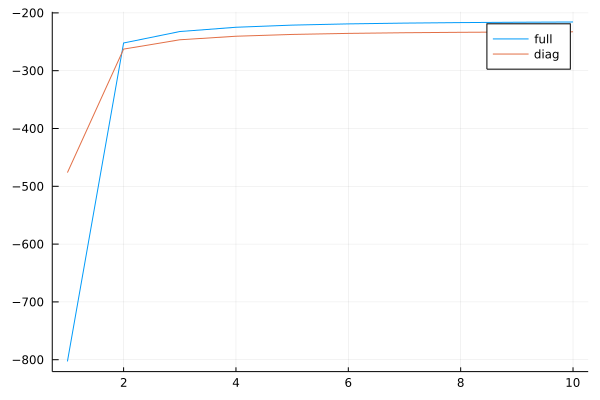

In [106]:
function fit(model, X; lrate = 0.1, steps = 1)
    elbos = []
    params = filter(isbayesianparam, getparams(model))

    for epoch in 1:epochs
        𝓛, ∇ξ = ∇elbo(model, X, params = params)
        gradstep(∇ξ, lrate = lrate)
        push!(elbos, 𝓛)
    end
    elbos
end


elbos_full = fit(model_full, X, steps = 10)
elbos_diag = fit(model_diag, X, steps = 10)
plot(elbos_full, label = "full")
plot!(elbos_diag, label = "diag")

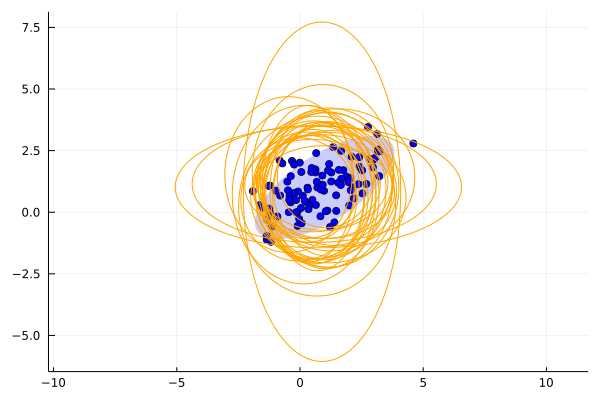

In [107]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model.μ.posterior, 30)
#Σs = [inv(Λₗ) for Λₗ in EFD.sample(model.Λ.posterior, 30)]
Σs = [diagm(1 ./ λₗ) for λₗ in eachrow(hcat(EFD.sample.(getproperty.(model.λ, :posterior), 30)...))]
for (μ, Σ) in zip(μs, Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

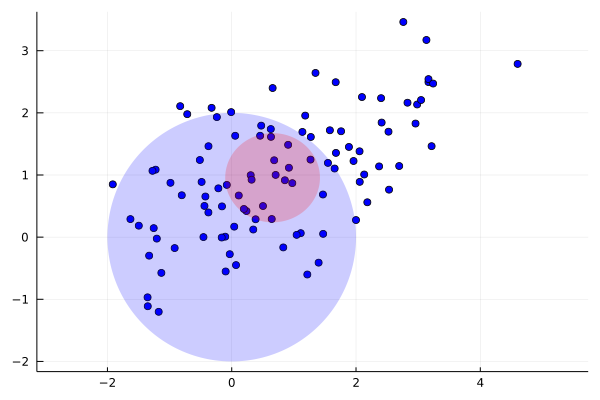

In [108]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model.μ.prior.μ, model.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model.μ.posterior.μ, model.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p